# Documentation

##### **Author**: *_Ernest Tashemi_*
##### **Objective**: *_To develop a model that predicts the probability that a transaction is fraudulent_*
##### **Last Modified**: *_07:35 PM | 20/10/25_* 
##### **Filename**: *_Fraud_Detection.ipynb_*

##### The **goal** is to build a fraud detection model, using ML algorithms trained on historical transaction data and then use the model to detect future fraudulent transactions.

##### The main steps in this notebook are:

##### 1. Import custom libraries
##### 2. Load & clean the data
##### 3. Understand and process the data through exploratory data analysis (EDA)
##### 4. Train three models using **logistic regression** and **boosting** techniques
##### 5. Combine the three models through a **soft-voting classifier**, to ensure best results
##### 6. Save the machine learning model and scalers used in production

# Import Statements

### The import statements below assume that libraries needed have already been installed in your local Python environment.

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

# Data Definition

### For the data definition, two techniques can be used:

## 1. Database Connection

In [2]:
driver = 'ODBC Driver 17 for SQL Server'
serverName = r'DESKTOP-OVEFBHA\SQLEXPRESS'
database = 'FraudDetectionDB'
tableName = 'CreditCardTransactions'

conn = pyodbc.connect(
    f"DRIVER={driver};"
    f"SERVER={serverName};DATABASE={database};Trusted_Connection=yes"
)

query = f"SELECT * FROM {tableName}"
df = pd.read_sql(query, conn) # type: ignore
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


## 2. Reading Raw .csv File

In [ ]:
dataFilePath = r"C:\Users\Ernest\Python Projects\CODAR_CAPSTONE_PROJECTS\Credit_Fraud_Detection\data\creditcard_data.csv"
df = pd.read_csv(dataFilePath)
df.head()

# Data Quality Checks

In [ ]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())

df = df.drop_duplicates()

## Clearing Bad Data

In [3]:
X = df.drop(columns=['Class'])
y = df['Class']

imputer = SimpleImputer(strategy='median')
X_cleaned = imputer.fit_transform(X)

df_cleaned = pd.DataFrame(X_cleaned, columns=X.columns)
df_cleaned['Class'] = y.values

df = df_cleaned.copy()

# Visuals

## Class Distribution (To show class imbalance)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


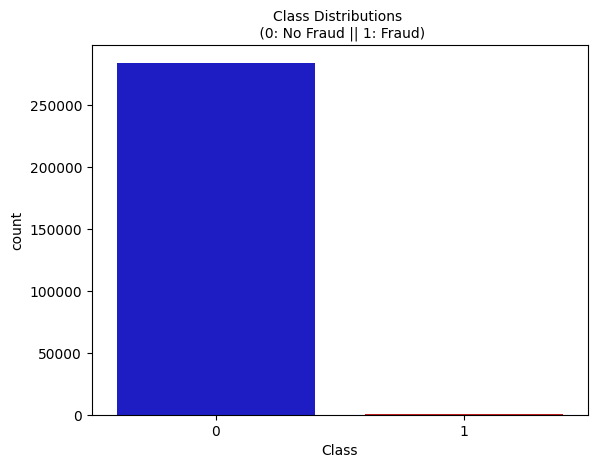

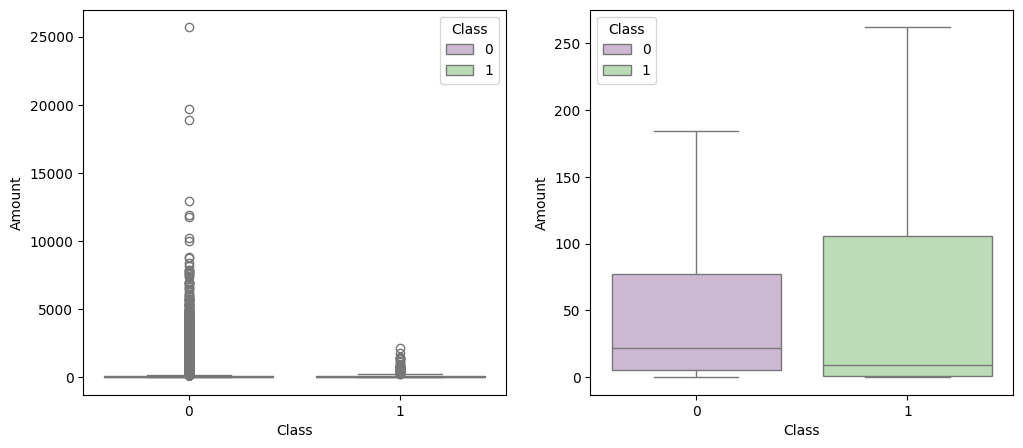

In [4]:
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df, palette=colors) 
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=10)

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn", showfliers=True) # Remove outliers from the plot
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn", showfliers=False) # Kepp outliers from the plot
plt.show()

## Time-based Fraud Patterns Analysis

In [ ]:
data = df.copy()
data['hour'] = (data['Time'] / 3600) % 24
data['hour_bin'] = data['hour'].astype(int)

fraud_rate_by_hour = data.groupby('hour_bin')['Class'].mean()

plt.figure(figsize=(10,5))
plt.bar(fraud_rate_by_hour.index, fraud_rate_by_hour.values) # type: ignore
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Oversampling and Model(s) Training & Evaluation

## SMOTE Application

In [5]:
X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)  # type: ignore

## Logistic Regression

### Model Training

In [6]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

y_pred_logreg = logreg.predict(X_test_scaled)
print("Logistic Regression Evaluation")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Evaluation
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



### Feature Importance

In [ ]:
logreg_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})

logreg_importance['abs_coef'] = logreg_importance['Coefficient'].abs()
logreg_importance = logreg_importance.sort_values(by='abs_coef', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Coefficient', y='Feature', data=logreg_importance.head(20), palette='coolwarm')
plt.title("Logistic Regression Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

## LightGBM

### Model Training

In [7]:
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train_res, y_train_res)

y_pred_lgb = lgb.predict(X_test_scaled)
print("LightGBM Evaluation")
print(classification_report(y_test, y_pred_lgb)) # type: ignore

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.88      0.63        98

    accuracy                           1.00     56962
   macro avg       0.74      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962



### Feature Importance

In [ ]:
lgb_importance = pd.DataFrame({'Feature': X.columns, 'Importance': lgb.feature_importances_}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=lgb_importance.head(20))
plt.title("LightGBM Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

## XGBoost

### Model Training

In [8]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

y_pred_xgb = xgb.predict(X_test_scaled)
print("XGBoost Evaluation")
print(classification_report(y_test, y_pred_xgb))

XGBoost Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.86      0.79        98

    accuracy                           1.00     56962
   macro avg       0.87      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962



### Feature Importance

In [ ]:
plt.figure(figsize=(12,6))
importance = xgb.feature_importances_
sns.barplot(x=importance, y=X.columns)
plt.title("XGBoost Feature Importance")
plt.show()

## Ensemble

### Model Ensembling (with _soft voting_ classifier)

In [9]:
voting_clf = VotingClassifier(estimators=[('logreg', logreg), ('xgb', xgb), ('lgb', lgb)], voting='soft') # type: ignore

voting_clf.fit(X_train_res, y_train_res)

y_pred_ensemble = voting_clf.predict(X_test_scaled)

print("Voting Classifier (Soft) Evaluation")
print(classification_report(y_test, y_pred_ensemble))

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Voting Classifier (Soft) Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.58      0.89      0.70        98

    accuracy                           1.00     56962
   macro avg       0.79      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962



### Cross-Validation Perfomance

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(voting_clf, X, y, cv=skf, scoring='roc_auc')

print("AUC scores:", scores)
print("Average AUC:", scores.mean())

[LightGBM] [Info] Number of positive: 393, number of negative: 227452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360885
[LightGBM] [Info] Start training from score -6.360885
[LightGBM] [Info] Number of positive: 393, number of negative: 227452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360885
[LightGBM] [Info] Start training from score -6.360885
[LightGBM] [

### Ensemble Feature Importances (from all models)

In [ ]:
# Logistic Regression
logreg_df = pd.DataFrame({
    'Feature': X.columns,
    'LogReg Importance': np.abs(logreg.coef_[0])
})

# XGBoost
xgb_df = pd.DataFrame({
    'Feature': X.columns,
    'XGB Importance': xgb.feature_importances_
})

# LightGBM
lgb_df = pd.DataFrame({
    'Feature': X.columns,
    'LightGBM Importance': lgb.feature_importances_
})

importance_df = logreg_df.merge(xgb_df, on='Feature').merge(lgb_df, on='Feature')

scaler = MinMaxScaler()
importance_df.iloc[:, 1:] = scaler.fit_transform(importance_df.iloc[:, 1:])

melted = importance_df.melt(id_vars="Feature", var_name="Model", value_name="Importance")


top_features = importance_df.set_index("Feature").mean(axis=1).sort_values(ascending=False).head(15).index
filtered = melted[melted["Feature"].isin(top_features)]

plt.figure(figsize=(14,8))
sns.barplot(data=filtered, x="Importance", y="Feature", hue="Model")
plt.title("Feature Importance Comparison: Logistic vs XGBoost vs LightGBM")
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Saving Model & Scalers  

In [ ]:
minMaxScalerPath = r"C:\Users\Ernest\Python Projects\CODAR_CAPSTONE_PROJECTS\Credit_Fraud_Detection\models\scalers\MinMax-Scaler.pkl"
minMaxScalerPCAPath = r"C:\Users\Ernest\Python Projects\CODAR_CAPSTONE_PROJECTS\Credit_Fraud_Detection\models\scalers\MinMax-Scaler_PCA.pkl"
logRegModelPath = r"C:\Users\Ernest\Python Projects\CODAR_CAPSTONE_PROJECTS\Credit_Fraud_Detection\models\logreg_model\logreg_model.pkl"
xgbModelPath = r"C:\Users\Ernest\Python Projects\CODAR_CAPSTONE_PROJECTS\Credit_Fraud_Detection\models\xgb_model\xgb_model.pkl"
lightGBMModelPath = r"C:\Users\Ernest\Python Projects\CODAR_CAPSTONE_PROJECTS\Credit_Fraud_Detection\models\lightgbm_model\lightgbm_model.pkl"
ensembleModelPath = r"C:\Users\Ernest\Python Projects\CODAR_CAPSTONE_PROJECTS\Credit_Fraud_Detection\models\ensemble_model\ensemble.pkl"

try:
    if not os.path.exists(minMaxScalerPath):
        joblib.dump(scaler, minMaxScalerPath)
        print("Scaler saved at: ", os.path.abspath("MinMax-Scaler.pkl"))

    if not os.path.exists(logRegModelPath):
        joblib.dump(logreg, logRegModelPath)
        print("Logistic regression model saved at: ", os.path.abspath("logreg_model.pkl"))

    if not os.path.exists(xgbModelPath):
        joblib.dump(xgb, xgbModelPath)
        print("XGBoost model saved at: ", os.path.abspath("xgb_model.pkl"))

    if not os.path.exists(lightGBMModelPath):
        joblib.dump(lgb, lightGBMModelPath)
        print("LightGBM model saved at: ", os.path.abspath("lightgbm_model.pkl"))

    if not os.path.exists(ensembleModelPath):
        joblib.dump(voting_clf, ensembleModelPath)
        print("Ensemble saved at: ", os.path.abspath("ensemble.pkl"))
except Exception:
    print("File Already Exists")